In [1]:
import os
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
import numpy as np
import json
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import random 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap
import segmentation_models_pytorch as smp

In [2]:
os.getcwd()

os.chdir('../')

os.getcwd()

'/Users/srikaranreddy/Desktop/Spring Semester/Computer Vision 6.8300/cv-project/gi-tract-image-segmentation'

In [3]:
from src.data import SegmentationDataset
from src.data import DataGenerator

CLASSES = ['small_bowel', 'large_bowel', 'stomach']

In [4]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1 - dice

def dice_coef_func(y_true, y_pred, smooth=1):
    y_true_f = y_true.contiguous().view(-1)
    y_pred_f = y_pred.contiguous().view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

In [5]:
train_generator_class = DataGenerator(dataset_dir='datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='datasets/coco/train_json.json',
                                     shuffle=True)

val_generator_class = DataGenerator(dataset_dir='datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='datasets/coco/val_json.json',
                                     shuffle=True)

test_generator_class = DataGenerator(dataset_dir='datasets/train',
                                     subset="test",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='datasets/coco/test_json.json',
                                     shuffle=False)

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def plot_masks(X, y):
    # Create custom colormaps for the masks
    cmap1 = ListedColormap(['none', 'red'])  # Mask 1 in red
    cmap2 = ListedColormap(['none', 'green'])  # Mask 2 in green
    cmap3 = ListedColormap(['none', 'blue'])  # Mask 3 in blue
    
    fig, ax = plt.subplots()
    # Display the grayscale image
    ax.imshow((X/255.)[:,:,0], cmap='gray')
    
    # Display the first mask
    ax.imshow(y[:,:,0], cmap=cmap1, alpha=0.5)
    
    # Display the second mask
    ax.imshow(y[:,:,1], cmap=cmap2, alpha=0.5)
    
    # Display the third mask
    ax.imshow(y[:,:,2], cmap=cmap3, alpha=0.5)
    
    # Create a legend for the masks
    red_patch = mpatches.Patch(color='red', label='Small Bowel')
    green_patch = mpatches.Patch(color='green', label='Large Bowel')
    blue_patch = mpatches.Patch(color='blue', label='Stomach')
    plt.legend(handles=[red_patch, green_patch, blue_patch])
    
    # Show the plot
    plt.show()

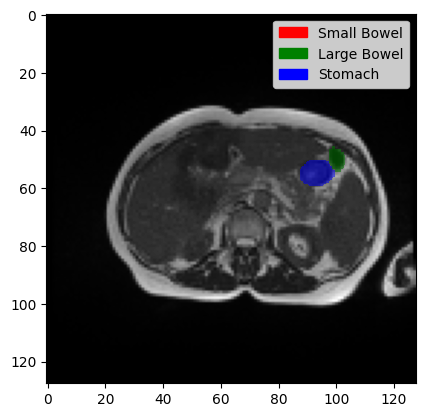

In [7]:
# Assuming X and y are loaded as mentioned
X, y = train_generator_class.__getitem__(9)

plot_masks(X, y)

In [8]:
train_loader = DataLoader(train_generator_class, batch_size=32, num_workers=0)
val_loader = DataLoader(val_generator_class, batch_size=32, num_workers=0)
test_loader = DataLoader(test_generator_class, batch_size=32, num_workers=0)

In [9]:
print("Batch size:", train_loader.batch_size)
print("Num workers:", train_loader.num_workers)
print("Dataset size:", len(train_loader.dataset))
print("Number of batches:", len(train_loader))

Batch size: 32
Num workers: 0
Dataset size: 14269
Number of batches: 446


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [11]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.InstanceNorm2d(out_channels)
        self.relu1 = nn.LeakyReLU(0.1)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.InstanceNorm2d(out_channels)
        self.relu2 = nn.LeakyReLU(0.1)
        self._init_weights()

    def forward(self, x):
        x = self.relu1(self.norm1(self.conv1(x)))
        x = self.relu2(self.norm2(self.conv2(x)))
        return x

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [12]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
        self._init_weights()

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

    def _init_weights(self):
        # Initialize weights for the transpose convolution
        nn.init.kaiming_normal_(self.up.weight, mode='fan_out', nonlinearity='relu')
        if self.up.bias is not None:
            nn.init.constant_(self.up.bias, 0)


In [15]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.inc = ConvBlock(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.outc = nn.Conv2d(64, 3, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        self._init_weights()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return self.sigmoid(logits)

    def _init_weights(self):
        # Initialize weights for the final output convolution
        nn.init.kaiming_normal_(self.outc.weight, mode='fan_out', nonlinearity='relu')
        if self.outc.bias is not None:
            nn.init.constant_(self.outc.bias, 0)


In [16]:
model = SimpleUNet()
input = torch.randn(1, 3, 128, 128)  # Example input
output = model(input)
print(output.shape)  # Should be torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])


In [17]:
model = SimpleUNet()  # Ensure your model is defined or loaded

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)

# Criterion
criterion = DiceLoss()

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = SimpleUNet().to(device)

# Optimizer and Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)

# Loss function
criterion = DiceLoss().to(device)

# Training and validation loops
train_losses = []
val_losses = []
train_dice_coefs = []
val_dice_coefs = []
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss_meter = AverageMeter()
    dice_coef_meter = AverageMeter()

    for data, target in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        target = target.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item(), data.size(0))
        dice_coef_meter.update(dice_coef_func(output, target).item(), data.size(0))

    train_losses.append(train_loss_meter.avg)
    train_dice_coefs.append(dice_coef_meter.avg)

    # Validation phase
    model.eval()
    val_loss_meter = AverageMeter()
    val_dice_coef_meter = AverageMeter()

    with torch.no_grad():
        for data, target in tqdm(val_loader, desc=f'Epoch {epoch} Validation'):
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 3, 1, 2)
            target = target.permute(0, 3, 1, 2)
            output = model(data)
            loss = criterion(output, target)

            val_loss_meter.update(loss.item(), data.size(0))
            val_dice_coef_meter.update(dice_coef_func(output, target).item(), data.size(0))

    val_losses.append(val_loss_meter.avg)
    val_dice_coefs.append(val_dice_coef_meter.avg)

    scheduler.step(val_loss_meter.avg)
    print(f'Epoch {epoch}: Train Loss: {train_loss_meter.avg:.4f}, Val Loss: {val_loss_meter.avg:.4f}, Train Dice: {dice_coef_meter.avg:.4f}, Val Dice: {val_dice_coef_meter.avg:.4f}')

    # Save model checkpoint
    torch.save(model.state_dict(), f'UNET_model_epoch_{epoch}.pth')


Using device: cpu


Epoch 0 Training:   0%|                                                                                                               | 0/446 [00:00<?, ?it/s]